In [25]:
import sys, os

MARIPOSA_PATH = "/home/yizhou7/mariposa/"

sys.path.append(MARIPOSA_PATH + "src")
os.chdir(MARIPOSA_PATH)

from debugger.debugger import DbgMode
from debugger.strainer import DebugStatus
from benchmark_consts import *

In [26]:
from base.factory import FACT

mp = FACT.get_project_by_path("data/projs/bench_unstable/base.z3")

exp = FACT.load_analysis(
        mp,
        cfg=FACT.get_config("default"),
        solver=FACT.get_solver("z3_4_12_5"),
        ana=FACT.get_analyzer("60sec"),
        allow_missing_exper=False,
    )


In [ ]:
import random
import numpy as np

random.seed(9321743958)

mariposa_ets = []

for qid in exp.qids:
    qr = exp[qid]
    passed, failed = exp.get_mutant_details(qr)
    adjusted = dict()

    for k, woot in passed.items():
        if woot[3] >= 60:
            failed[k] = woot
        else:
            adjusted[k] = woot   
    passed = adjusted    

    fmut = random.choice(list(failed.keys()))
    _, _, _, fet = failed[fmut]
    pmut = random.choice(list(passed.keys()))
    _, _, _, pet = passed[pmut]
    mariposa_ets += [(fet, pet)]

# fstar_queries = np.array(fstar_queries)
# dafny_queries = np.array(dafny_queries)
mariposa_ets = np.array(mariposa_ets)

In [ ]:
VERUS_PROJS = ["verismo.dedup", "vsystemsnew", "anvil", "splinterdb", "flowcert", "atmosphere"]

verus_ets = []
for p in VERUS_PROJS:
    proj = FACT.get_project_by_path("data/projs/" + p + "/base.z3")
    exp = FACT.load_analysis(
        proj,
        cfg=FACT.get_config("default"),
        solver=FACT.get_solver("z3_4_13_0"),
        ana=FACT.get_analyzer("10sec"),
        allow_missing_exper=False,
    )
    for qid in exp.qids:
        qer = exp[qid]
        if qer.query_path not in UNSTABLE_VERUS:
            continue
        passed, failed = exp.get_mutant_details(qer)
        adjusted = dict()
        for k, woot in passed.items():
            if woot[3] >= 10:
                failed[k] = woot
            else:
                adjusted[k] = woot   
        passed = adjusted
        fmut = random.choice(list(failed.keys()))
        _, _, _, fet = failed[fmut]
        pmut = random.choice(list(passed.keys()))
        _, _, _, pet = passed[pmut]
        verus_ets += [(fet, pet)]
    
verus_ets = np.array(verus_ets)

In [33]:
# print(verus_ets)
print(mariposa_ets)

[[ 4.01  2.71]
 [ 0.33  0.32]
 [19.72  4.34]
 ...
 [ 0.06  0.06]
 [ 0.09  0.5 ]
 [60.    1.43]]


In [29]:
# from debugger.bench_viewer import BenchViewer
# from debugger.debugger_options import DebugOptions

# options = DebugOptions()
# # remember to set this!
# options.is_verus = True
# verus_bench = BenchViewer(UNSTABLE_VERUS, options)

In [30]:
from utils.analysis_utils import *
from utils.plot_utils import *

mariposa_ets = mariposa_ets.clip(0, 60)
assert mariposa_ets.shape[0] == len(UNSTABLE_MARIPOSA)

verus_ets = verus_ets.clip(0, 10)
assert verus_ets.shape[0] == len(UNSTABLE_VERUS)

In [31]:
mariposa_fail_cdf = PartialCDF(mariposa_ets[:,0])
mariposa_pass_cdf = PartialCDF(mariposa_ets[:,1])
verus_fail_cdf = PartialCDF(verus_ets[:,0])
verus_pass_cdf = PartialCDF(verus_ets[:,1])

In [ ]:
plt.scatter(mariposa_ets[:,0], mariposa_ets[:,1], c=BENCH_COLORS["mariposa"])
plt.scatter(verus_ets[:,0], verus_ets[:,1], c=BENCH_COLORS["verus"])

# Adding labels and title to the scatter plot
plt.xlabel("Time Until Mutant Failure Log Scale (s)")
plt.ylabel("Time Until Mutant Success Log Scale (s)")
# plt.title("Scatter Plot of Execution Times")
plt.xlim(0.02, 60.2)
plt.xticks([0.02, 0.1, 1, 10, 60], ["", "0.1", "1.0", "10.0", "60.0"])

plt.ylim(0.02, 60.2)
plt.yticks([0.02, 0.1, 1, 10, 60], ["", "0.1", "1.0", "10.0", "60.0"])

plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.legend(["Mariposa-bench", "Verus-bench"], loc="upper left")
plt.grid()
plt.xscale("log")
plt.yscale("log")
plt.savefig("fig/debugger/pass_fail.pdf")
plt.clf()

<Figure size 640x480 with 0 Axes>

1.1 13.970588235294118


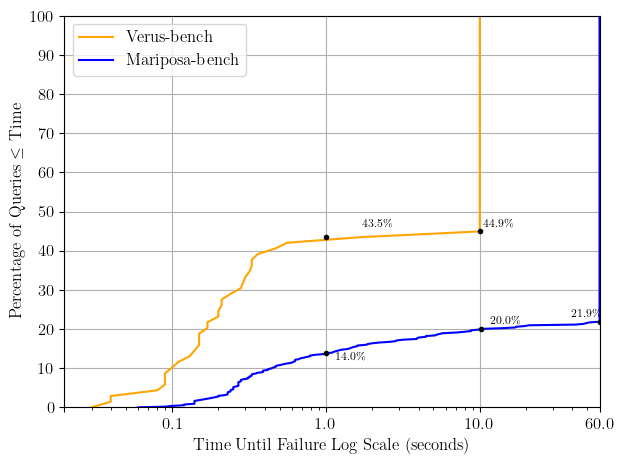

In [59]:
# plt.plot(verus_pass_cdf.xs, verus_pass_cdf.ys, label="Verus Pass")
# plt.plot(mariposa_pass_cdf.xs, mariposa_pass_cdf.ys, label="Mariposa  Pass")

plt.plot(verus_fail_cdf.xs, verus_fail_cdf.ys, label="Verus-bench", color=COLORS["verus"])

x, y = verus_fail_cdf.get_point_by_value(0.8, False)
plt.plot(1, y, c="black", marker="o", markersize=3)
plt.text(
    x, y+2, f"{round(y, 1)}\%", fontsize=8, va="bottom"
)

x, y = verus_fail_cdf.get_point_by_value(9.9, True)
plt.plot(x, y, c="black", marker="o", markersize=3)
plt.text(
    x * 1.05, y + 3, f"{round(y, 1)}\%", fontsize=8, va="top", ha="left"
)

plt.plot(mariposa_fail_cdf.xs, mariposa_fail_cdf.ys, label="Mariposa-bench",  color=COLORS["mariposa"])

x, y = mariposa_fail_cdf.get_point_by_value(10, True)
plt.plot(x, y, c="black", marker="o", markersize=3)
plt.text(
    x * 1.15, y+3, f"{round(y, 1)}\%", fontsize=8, va="top"
)

x, y = mariposa_fail_cdf.get_point_by_value(1, True)
print(x, y)
plt.plot(1, y, c="black", marker="o", markersize=3)
plt.text(
    x * 1.05, y, f"{round(y, 1)}\%", fontsize=8, va="top"
)

x, y = mariposa_fail_cdf.get_point_by_value(59.1, True)
plt.plot(x, y, c="black", marker="o", markersize=3)
plt.text(
    x * 1.03, y + 3, f"{round(y, 1)}\%", fontsize=8, va="top", ha="right"
)

# plt.axvline(x=1, ymin=0, ymax=0.42,color='gray', linestyle='--')
# plt.axhline(y=42, xmin=0, xmax=0.5, color='gray', linestyle='--')

plt.plot()
plt.xscale("log")

plt.yticks(np.arange(0, 101, 10))
plt.xlim(0.02, 60.2)
plt.xticks([0.02, 0.1, 1, 10, 60], ["", "0.1", "1.0", "10.0", "60.0"])
plt.ylim(0, 100)

plt.legend()
# plt.title("Distinct Instability Failure Modes")
plt.xlabel("Time Until Failure Log Scale (seconds)")
plt.ylabel("Percentage of Queries $\leq$ Time")

plt.grid()
plt.tight_layout()
plt.savefig("fig/debugger/failure_modes.pdf", dpi=600, format="pdf")